# Incrementing the Observations to Estimate all the Parameters in Fractional Additive SDEs

We consider the following one-dimensional Onrstein-Uhlenbeck process $$dY = -\xi_0 Y_s dt + \sigma_0 dB^{H_0}.$$ We have access to discrete observations of $Y$ of the form $\{Y_{kh}, k=1,2,..\}$ and we want to estimate the parameters $\xi_0,\sigma_0$ and $H_0$. The estimation procedure is based on minimizing the distance:
$$ \theta = (\xi,\sigma,H) \rightarrow d(\frac{1}{n} \sum_1^n \delta_{X_{kh}}, \frac{1}{N} \sum_1^{N} \delta_{L^{\theta}_{k\gamma}})$$
where $d$ is a distance that is bounded by the $p$-Wassertein distance and $$X_. = (Y_., Y_{.+h}-Y_., Y_{.+2h}-Y_.,...,Y_{.+qh}-Y_)$$ is a vector that contains the solution $Y$ and its increments. Similarly, $$L^\theta_.= (M^\theta_., M^\theta_{.+h}-M^\theta_., M^\theta_{.+2h}-M^\theta_.,...,M^\theta_{.+qh}-M^\theta_.)$$ where $M^\theta$ is a simulated O-U process with the parameters $\xi,\sigma$ and $H$ (through a Euler scheme of step size $\gamma$).

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

## I. Simulation of the fractional Brownian motion

We simulate the fractional Brownian motion using the Davies-Harte method.

In [2]:
def davies_harte(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=np.complex); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=np.complex)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path

def fBm(T,N,H,trials):
    B = np.zeros((N+1,trials))
    for i in range(trials):
        B[:,i] = np.real(davies_harte(T,N,H))
    return B    
    

Example: Brownian Motion

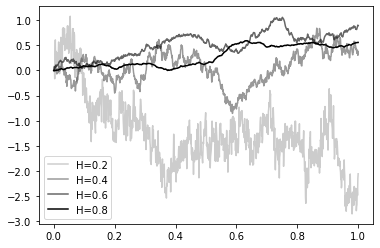

In [3]:
t = np.linspace(0,1,1001)
B08 = fBm(1,1000,0.8,1)
B04 = fBm(1,1000,0.4,1)
B06 = fBm(1,1000,0.6,1)
B02 = fBm(1,1000,0.2,1)
plt.plot(t,B02,color='black', alpha=0.2, label='H=0.2')
plt.plot(t,B04, color='black', alpha=0.4, label='H=0.4')
plt.plot(t,B06, color='black', alpha=0.6, label='H=0.6')
plt.plot(t,B08, color='black', label='H=0.8')
plt.legend()
plt.savefig("fBmpaths.pdf")

## II. Simulation of the fractional O-U process


We simulate the fractional O-U process through a Euler scheme.

In [4]:
def ornstein_uhlenbeck(dt,n,drift,sigma,H):
    T = dt*n
    trials = 1
    B = fBm(T,n,H,trials)
    x = np.zeros((n+1,trials))
    for i in range(n):
        x[i+1,:] = x[i,:] - dt * x[i,:] * drift + sigma*(B[i+1,:]-B[i,:])
    return x[:,0]  

 

Example:

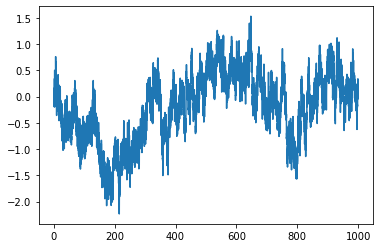

In [5]:
OU1=ornstein_uhlenbeck(0.001,10000,1,1,0.3)
OU2=ornstein_uhlenbeck(0.001,10000,1,1,0.5)
R = abs(OU1-OU2)/(0.2**0.9)
t = np.linspace(0,1000,10001)
plt.plot(t,OU1)

## III. Extraction of the sample

Given a set of parameters $\theta$, we extract the associated sample $X^\theta$

In [6]:
def increments(x,q):
    n = len(x)-q
    X = np.zeros((n,q))
    for i in range(1,q):
        X[:,i] = x[i:i+n] - x[0:n]
    X[:,0] = x[0:n]    
    return X    


def true_sample(n,q,h,xi,sigma,H):
    dt = 0.001
    x = ornstein_uhlenbeck(dt,int((n+q)*(h/dt)), xi, sigma, H)
    good_indices = [i for i in range(int((n+q)*(h/dt))) if i % int(1/h) == 0]
    x = np.array([x[i] for i in good_indices])
    X = increments(x,q)
    return X

def euler_sample(n,q,gamma,xi,sigma,H):
    x = ornstein_uhlenbeck(gamma,n+q, xi, sigma, H)
    X = increments(x,q)
    return X
    
    

Example:

In [7]:
true_sample(100,3,1,1,0.1,0.5)
#euler_sample(10000,3,0.01,1,0.1,0.5)

array([[ 0.        ,  0.00249914,  0.00174738],
       [ 0.00249914, -0.00075176,  0.00250367],
       [ 0.00174738,  0.00325543, -0.00164209],
       ...,
       [ 0.02767328,  0.0013213 , -0.00130817],
       [ 0.02899458, -0.00262947,  0.00258656],
       [ 0.02636511,  0.00521602,  0.00620072]])

## VI. Minimization procedure: Estimation of one parameters (Gradient descent)

In [8]:
trials = 100
N = 10000
n = 1000
h = 0.1
timestep = 0.1
xi = 2
sigma = 0.5
H = 0.7
p = 2

In [10]:
# pb=1 -> xi and H, pb=2 -> xi and sigma, pb=3 -> H and sigma
def random_va(trials):
    u = np.random.uniform(0,2*pi,trials)
    v = np.random.uniform(0,1,trials)
    v = (v**(1/(1-3)) - 1)**(1/2)
    res = np.zeros((2,trials))
    res[0,:] = v*np.cos(u)
    res[1,:] = v*np.sin(u)
    return res

#eta = random_va(100)
#z= euler_sample(N,2,timestep,xi,sigma,H)
#print(np.shape(z), np.shape(x), np.shape(eta))
#scalar_p_sample = np.zeros((n,trials))
#scalar_p_euler = np.zeros((N,trials))
#for k in range(n):
    #print(np.transpose(eta),x[k,:])
#    scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
#for k in range(N):
#    scalar_p_euler[k,:] = eta[0,:]*z[k,0] #+ eta[1,:]*z[k,1]
#    
#av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
#av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
#diff = av_cos_sample-av_cos_euler
#print(np.mean(diff**2))

In [11]:
def loss_drift(theta,x):
    z= euler_sample(N,2,timestep,theta,sigma,H)
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_drift(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    var = (sigma**2)*(H*gamma(2*H) )*theta**(-2*H)
    av_cos_euler = np.exp(-var*eta**2/2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def loss_hurst(theta,x):
    z= euler_sample(N,2,timestep,xi,sigma,theta)
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]    
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_hurst(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    var = (sigma**2)*(H*gamma(2*theta) )*xi**(-2*theta)
    av_cos_euler = np.exp(-var*eta**2/2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def loss_diffusion(theta,x):
    z= euler_sample(N,2,timestep,xi,theta,H)
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):       
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_diffusion(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    var = (theta**2)*(H*gamma(2*H) )*xi**(-2*H)
    av_cos_euler = np.exp(-var*eta**2/2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def grad_drift(theta,delta,x):
    grad = (loss_drift(theta+delta,x)-loss_drift(theta,x))/delta
    return np.array(grad)

def grad_diffusion(theta,delta,x):
    grad = (loss_diffusion(theta+delta,x)-loss_diffusion(theta,x))/delta
    return np.array(grad)

def grad_hurst(theta,delta,x):
    grad = (loss_hurst(theta+delta,x)-loss_hurst(theta,x))/delta
    return np.array(grad)


def oracle_grad_drift(theta,delta,x):
    grad = (oracle_loss_drift(theta+delta,x)-oracle_loss_drift(theta,x))/delta
    return np.array(grad)

def oracle_grad_diffusion(theta,delta,x):
    grad = (oracle_loss_diffusion(theta+delta,x)-oracle_loss_diffusion(theta,x))/delta
    return np.array(grad)

def oracle_grad_hurst(theta,delta,x):
    grad = (oracle_loss_hurst(theta+delta,x)-oracle_loss_hurst(theta,x))/delta
    return np.array(grad)

def descent_drift(step,delta,x):
    v0 = np.array([1.5])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_drift(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_drift(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_drift(v,delta,x)
        if jac == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v<0:
            v=v0
        #print(jac,v,loss_drift(v,x))
    return v  

def descent_hurst(step,delta,x):
    v0 = np.array([0.6])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_hurst(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_hurst(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_hurst(v,delta,x)
        if jac == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v < 0 or v >1:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 

def descent_diffusion(step,delta,x):
    v0 = np.array([0.7])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_diffusion(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_diffusion(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_diffusion(v,delta,x)
        if jac == nan:
            v=v0
        if v <0 :
            v = v0
        v = v- step*jac*(i+1)**(-1)
        #print(jac,v,loss_drift(v,x))
    return v 


def oracle_descent_drift(step,delta,x):
    v0 = np.array([1.5])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_drift(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_drift(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_drift(v,delta,x)
        if jac == nan:
            v=v0    
        v = v- step*jac*(i+1)**(-1)
        if v<0:
            v=v0
        #print(jac,v,oracle_loss_drift(v,x))
    return v  

def oracle_descent_hurst(step,delta,x):
    v0 = np.array([0.65])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_hurst(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_hurst(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_hurst(v,delta,x)
        if jac == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v < 0 or v >1:
            v = v0
        #print(jac,v,oracle_loss_hurst(v,x))
    return v 

def oracle_descent_diffusion(step,delta,x):
    v0 = np.array([0.7])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_diffusion(v,delta,x)
        timer = 0
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_diffusion(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_diffusion(v,delta,x)
        if jac == nan:
            v=v0
        if v <0:
            v = v0
        v = v- step*jac*(i+1)**(-1)
        #print(jac,v,oracle_loss_diffusion(v,x))
    return v 


In [12]:
def estimator_drift(trials):
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_drift(2,1e-1,x)
        res_oracle = oracle_descent_drift(2,1e-1,x)
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    plt.hist(oracle, bins= 15, histtype='barstacked', color='gray', label='oracle')
    plt.hist(estimates, bins= 15, histtype='barstacked', color='#FF000000', ec='darkgray',hatch='/', label='estimate')
    plt.axvline(np.mean(estimates), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
    plt.axvline(2, color='k', linewidth=1)
    plt.title('Drift estimation',fontweight="bold", fontsize=10)
    plt.legend()
    plt.savefig("histdrift2.pdf")
    print('empirical mean = ',np.mean(estimates), 'empirical variance= ', np.var(estimates)) 
    print('oracle mean = ',np.mean(oracle), 'oracle variance= ', np.var(oracle)) 

100%|██████████| 20/20 [01:47<00:00,  5.38s/it]


empirical mean =  1.6029320378902223 empirical variance=  0.04220804492143214
oracle mean =  1.5455205013605153 oracle variance=  0.07133551045904875


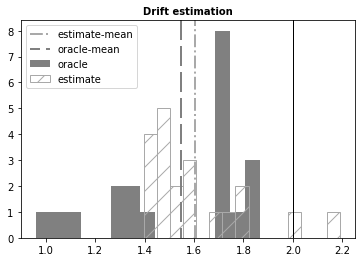

In [13]:
estimator_drift(20)

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-4-209ed2c80b7e>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]
100%|██████████| 40/40 [06:00<00:00,  9.02s/it]

empirical mean =  0.7333177526757942 empirical variance=  0.009855746292697417
oracle mean =  0.6923511193699984 oracle variance=  0.01919267593071815


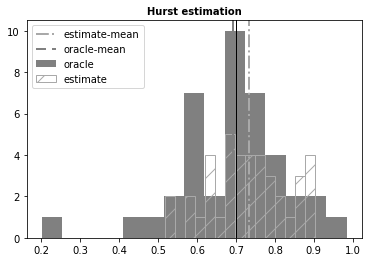

In [172]:
def estimator_hurst(trials):
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_hurst(2,1e-1,x)
        res_oracle= oracle_descent_hurst(2,1e-1,x)
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    plt.hist(oracle, bins= 15, histtype='barstacked', color='gray', label='oracle')
    plt.hist(estimates, bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray', hatch='/', label='estimate')
    plt.axvline(np.mean(estimates), color='darkgray', linestyle= '-.', linewidth=2, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
    plt.axvline(0.7, color='k', linewidth=1)
    plt.title('Hurst estimation',fontweight="bold", fontsize=10)
    plt.legend()
    plt.savefig("histhurst2.pdf")
    print('empirical mean = ',np.mean(estimates), 'empirical variance= ', np.var(estimates)) 
    print('oracle mean = ',np.mean(oracle), 'oracle variance= ', np.var(oracle))
    
estimator_hurst(40)    

100%|██████████| 20/20 [03:35<00:00, 10.78s/it]

empirical mean =  0.6018048583264981 empirical variance=  0.27344677164785686


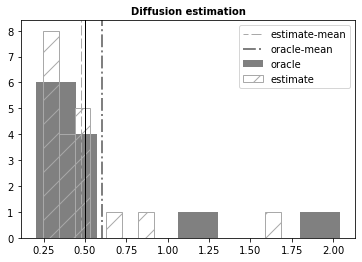

In [161]:
def estimator_diffusion(trials):
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_diffusion(2,1e-1,x)
        res_oracle = oracle_descent_diffusion(2,1e-1,x)
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    plt.hist(oracle, bins= 15, histtype='barstacked', color='gray', label='oracle')    
    plt.hist(estimates, bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray', hatch='/', label='estimate')
    plt.axvline(np.mean(estimates), color='darkgray', linestyle=(5, (10, 3)), linewidth=1, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle='-.', linewidth=2, label='oracle-mean')
    plt.axvline(0.5, color='k', linewidth=1)
    plt.title('Diffusion estimation',fontweight="bold", fontsize=10)
    plt.legend()
    plt.savefig("histdiffusion2.pdf")
    print('empirical mean = ',np.mean(oracle), 'empirical variance= ', np.var(oracle)) 
    
estimator_diffusion(20)  

# TWO PARAMETERS COMPARISON

In [22]:
#1= xi, 2=H, 3=sigma
from scipy.special import psi
from tqdm import tqdm
from scipy.special import gamma
import scipy.integrate as integrate

def cov_matrix(xi,H,sigma):
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    non_diag = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  - (sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)
    diag_1 = (sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)
    diag_2 = 2*(sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  
    cov = np.zeros((2,2))
    cov[0,0]=diag_1
    cov[1,1]=diag_2
    cov[0,1]= non_diag
    cov[1,0] = non_diag
    return cov

def partial_cov(xi,H,sigma):
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    non_diag = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_1 = (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_2 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I/pi  
    cov_sigma =  [[diag_1, non_diag],[non_diag,diag_2]]
    

    I = integrate.quad(lambda x: -cos(h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I = I[0]
    non_diag = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  - (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_1 = (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_2 = 2*(-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  
    cov_xi =  [[diag_1, non_diag],[non_diag,diag_2]]
    
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    II = integrate.quad(lambda x: (-2*log(x))*cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II = II[0]
    non_diag = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II/pi  - (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) - (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_1 = (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) + (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_2 = 2*diag_1 -2*( (sigma**2)*gamma(2*H+1)*cos(pi*H)*I + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II/pi  )
    cov_H =  [[diag_1, non_diag],[non_diag,diag_2]]
    
    return [cov_xi, cov_H, cov_sigma]

In [23]:
# pb=1 -> xi and H, pb=2 -> xi and sigma, pb=3 -> H and sigma
from numpy import linalg as LA

def loss_drift_hurst(theta,x):
    z= euler_sample(N,2,timestep,theta[0],sigma,theta[1])
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_drift_hurst(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    #I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)    
    cov = cov_matrix(theta[0],theta[1],sigma)
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:,tt],np.dot(cov,eta[:,tt])/2))
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

In [24]:
def loss_hurst_sigma(theta,x):
    z= euler_sample(N,2,timestep,xi,theta[0],theta[1])
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_hurst_sigma(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    cov = cov_matrix(xi,theta[1],theta[0])
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:,tt],np.dot(cov,eta[:,tt])/2))
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def loss_diffusion_drift(theta,x):
    z= euler_sample(N,2,timestep,theta[0],theta[1],H)
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    scalar_p_euler = np.zeros((N,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def oracle_loss_diffusion_drift(theta,x):
    eta = random_va(100)
    scalar_p_sample = np.zeros((n,trials))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1]   
    cov = cov_matrix(theta[0],H,theta[1])
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:,tt],np.dot(cov,eta[:,tt])/2))
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return 10*np.mean(diff**2)

def grad_drift_hurst(theta,delta,x):
    grad1 = (loss_drift_hurst(np.array([theta[0]+delta,theta[1]]),x)-loss_drift_hurst(theta,x))/delta
    grad2 = (loss_drift_hurst(np.array([theta[0],theta[1]+delta]),x)-loss_drift_hurst(theta,x))/delta
    return np.array([grad1,grad2])

def grad_diffusion_drift(theta,delta,x):
    grad1 = (loss_diffusion_drift(np.array([theta[0]+delta,theta[1]]),x)-loss_diffusion_drift(theta,x))/delta
    grad2 = (loss_diffusion_drift(np.array([theta[0],theta[1]+delta]),x)-loss_diffusion_drift(theta,x))/delta
    return np.array([grad1,grad2])

def grad_hurst_sigma(theta,delta,x):
    grad1 = (loss_hurst_sigma(np.array([theta[0]+delta,theta[1]]),x)-loss_hurst_sigma(theta,x))/delta
    grad2 = (loss_hurst_sigma(np.array([theta[0],theta[1]+delta]),x)-loss_hurst_sigma(theta,x))/delta
    return np.array([grad1,grad2])


def oracle_grad_drift_hurst(theta,delta,x):
    grad1 = (oracle_loss_drift_hurst(np.array([theta[0]+delta,theta[1]]),x)-oracle_loss_drift_hurst(theta,x))/delta
    grad2 = (oracle_loss_drift_hurst(np.array([theta[0],theta[1]+delta]),x)-oracle_loss_drift_hurst(theta,x))/delta
    return np.array([grad1,grad2])

def oracle_grad_diffusion_drift(theta,delta,x):
    grad1 = (oracle_loss_diffusion_drift(np.array([theta[0]+delta,theta[1]]),x)-oracle_loss_diffusion_drift(theta,x))/delta
    grad2 = (oracle_loss_diffusion_drift(np.array([theta[0],theta[1]+delta]),x)-oracle_loss_diffusion_drift(theta,x))/delta
    return np.array([grad1,grad2])

def oracle_grad_hurst_sigma(theta,delta,x):
    grad1 = (oracle_loss_hurst_sigma(np.array([theta[0]+delta,theta[1]]),x)-oracle_loss_hurst_sigma(theta,x))/delta
    grad2 = (oracle_loss_hurst_sigma(np.array([theta[0],theta[1]+delta]),x)-oracle_loss_hurst_sigma(theta,x))/delta
    return np.array([grad1,grad2])

def descent_drift_hurst(step,delta,x):
    v0 = np.array([1.5,0.6])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_drift_hurst(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_drift_hurst(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_drift_hurst(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] < 0 or v[1] >1:
            v = v0
        #print(jac,v,loss_drift_hurst(v,x))
    return v  

def descent_hurst_sigma(step,delta,x):
    v0 = np.array([0.7,0.6])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_hurst_sigma(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_hurst_sigma(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_hurst_sigma(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] < 0 or v[1] >1 or v[0]<0:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 

def descent_diffusion_drift(step,delta,x):
    v0 = np.array([1.5,1])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = grad_diffusion_drift(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_diffusion_drift(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_diffusion_drift(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] <0 or v[0]<0 :
            v = v0
        #print(jac,v,loss_drift_hurst(v,x))
    return v 


def oracle_descent_drift_hurst(step,delta,x):
    v0 = np.array([1.5,0.6])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_drift_hurst(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_drift_hurst(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_drift_hurst(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] < 0 or v[1] >1:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v  

def oracle_descent_hurst_sigma(step,delta,x):
    v0 = np.array([0.7,0.6])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_hurst_sigma(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_hurst_sigma(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_hurst_sigma(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] < 0 or v[1] >1 or v[0]<0:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 

def oracle_descent_diffusion_drift(step,delta,x):
    v0 = np.array([1.5,1])
    maxiter=10
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_diffusion_drift(v,delta,x)
        timer = 0
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_diffusion_drift(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_diffusion_drift(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] <0 or v[0]<0 :
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 




In [25]:
def estimator_drift_hurst(trials):
    estimates = np.zeros((2,trials))
    oracle = np.zeros((2,trials))
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_drift_hurst(2,1e-1,x)
        res_oracle = oracle_descent_drift_hurst(2,1e-1,x)
        oracle[:,trial] = res_oracle
        estimates[:,trial] = res
    return [oracle, estimates]    
    #plt.hist(estimates, bins= 15, histtype='barstacked', color='gray',hatch='/')
    #plt.hist(oracle, bins= 15, histtype='barstacked', color='gray')
    #plt.axvline(np.mean(estimates), color='gray', linestyle='-.', linewidth=1, label='estimate')
    #plt.axvline(np.mean(oracle), color='k', linestyle=(5, (10, 3)), linewidth=1, label='oracle')
    #plt.axvline(2, color='k', linewidth=1)
    #plt.title('Drift & Hurst estimation',fontweight="bold", fontsize=10)
    #plt.legend()
    #plt.savefig("histdrift-hurst.pdf")
    #print('empirical mean = ',np.mean(estimates, axis=1), 'empirical variance= ', np.var(estimates, axis=1)) 

In [100]:
oracle_drift_hurst, estimates_drift_hurst = estimator_drift_hurst(20)

 20%|██        | 4/20 [00:45<03:01, 11.33s/it]<ipython-input-96-ee86773b6df3>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
100%|██████████| 20/20 [04:30<00:00, 13.53s/it]


empirical mean =  0.6921257228991821 empirical variance=  0.021881131586432033
oracle mean =  0.7153573516956466 empirical variance=  0.029530652370237227


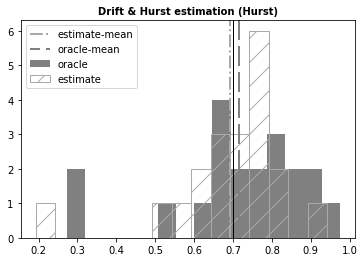

In [147]:
plt.hist(oracle_drift_hurst[1,:], bins= 15, histtype='barstacked', color='gray', label='oracle')
plt.hist(estimates_drift_hurst[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/', label='estimate')
plt.axvline(np.mean(estimates_drift_hurst[1,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_drift_hurst[1,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('Drift & Hurst estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdrift-hurst(hurst).pdf")
print('empirical mean = ',np.mean(estimates_drift_hurst[1,:]), 'empirical variance= ', np.var(estimates_drift_hurst[1,:])) 
print('oracle mean = ',np.mean(oracle_drift_hurst[1,:]), 'empirical variance= ', np.var(oracle_drift_hurst[1,:])) 

empirical mean =  1.6508561386505778 empirical variance=  0.087411777741329
oracle mean =  1.6941214489229224 empirical variance=  0.25566645796764814


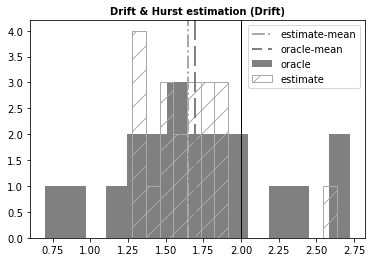

In [146]:
plt.hist(oracle_drift_hurst[0,:], bins= 15, histtype='barstacked', color='gray', label='oracle')
plt.hist(estimates_drift_hurst[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/', label='estimate')
plt.axvline(np.mean(estimates_drift_hurst[0,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_drift_hurst[0,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('Drift & Hurst estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdrift-hurst(drift).pdf")
print('empirical mean = ',np.mean(estimates_drift_hurst[0,:]), 'empirical variance= ', np.var(estimates_drift_hurst[0,:])) 
print('oracle mean = ',np.mean(oracle_drift_hurst[0,:]), 'empirical variance= ', np.var(oracle_drift_hurst[0,:])) 

In [26]:
def estimator_hurst_sigma(trials):
    estimates = np.zeros((2,trials))
    oracle = np.zeros((2,trials))
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_hurst_sigma(2,1e-1,x)
        res_oracle = oracle_descent_hurst_sigma(2,1e-1,x)
        oracle[:,trial] = res_oracle
        estimates[:,trial] = res
    return [oracle, estimates]

In [131]:
oracle_hurst_sigma , estimates_hurst_sigma = estimator_hurst_sigma(20)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-96-ee86773b6df3>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
100%|██████████| 20/20 [05:30<00:00, 16.51s/it]


empirical mean =  0.3484894568113495 empirical variance=  0.01311022042402554
oracle mean =  0.45639887585405675 oracle variance=  0.016427798184267213


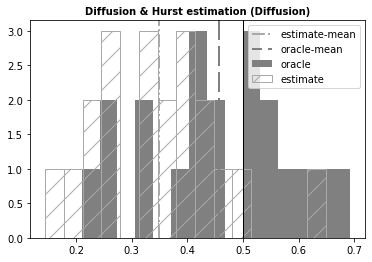

In [148]:
plt.hist(oracle_hurst_sigma[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_hurst_sigma[0,:], bins= 15, histtype='barstacked', color='#FF000000', ec= 'darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_hurst_sigma[0,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_hurst_sigma[0,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('Diffusion & Hurst estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-hurst(diffusion).pdf")
print('empirical mean = ',np.mean(estimates_hurst_sigma[0,:]), 'empirical variance= ', np.var(estimates_hurst_sigma[0,:]))
print('oracle mean = ',np.mean(oracle_hurst_sigma[0,:]), 'oracle variance= ', np.var(oracle_hurst_sigma[0,:])) 

empirical mean =  0.6164252217144564 empirical variance=  0.01746211912972256
oracle mean =  0.7640769922962078 oracle variance=  0.029196363029405186


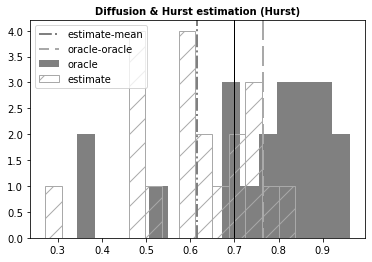

In [149]:
plt.hist(oracle_hurst_sigma[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_hurst_sigma[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_hurst_sigma[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_hurst_sigma[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-oracle')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('Diffusion & Hurst estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-hurst(hurst).pdf")
print('empirical mean = ',np.mean(estimates_hurst_sigma[1,:]), 'empirical variance= ', np.var(estimates_hurst_sigma[1,:]))
print('oracle mean = ',np.mean(oracle_hurst_sigma[1,:]), 'oracle variance= ', np.var(oracle_hurst_sigma[1,:])) 

In [27]:
def estimator_diffusion_drift(trials):
    estimates = np.zeros((2,trials))
    oracle = np.zeros((2,trials))
    for trial in tqdm(range(trials)):
        x = true_sample(n,2,h,xi,sigma,H)
        res = descent_diffusion_drift(2,1e-1,x)
        res_oracle = oracle_descent_diffusion_drift(2,1e-1,x)
        oracle[:,trial] = res_oracle
        estimates[:,trial] = res
    return [oracle, estimates]

In [112]:
oracle_diffusion_drift, estimates_diffusion_drift = estimator_diffusion_drift(20)

100%|██████████| 20/20 [13:49<00:00, 41.48s/it]


empirical mean =  1.9452707833740095 empirical variance=  0.23979868129331122
oracle mean =  1.9074231210090562 oracle variance=  0.4656990282150691


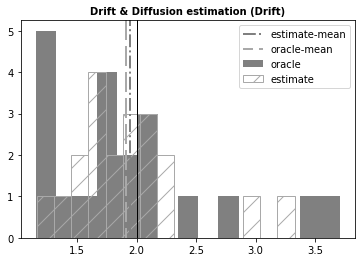

In [153]:
plt.hist(oracle_diffusion_drift[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_diffusion_drift[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_diffusion_drift[0,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_diffusion_drift[0,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('Drift & Diffusion estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-drift(drift).pdf")
print('empirical mean = ',np.mean(estimates_diffusion_drift[0,:]), 'empirical variance= ', np.var(estimates_diffusion_drift[0,:]))
print('oracle mean = ',np.mean(oracle_diffusion_drift[0,:]), 'oracle variance= ', np.var(oracle_diffusion_drift[0,:])) 

empirical mean =  0.5120453872700538 empirical variance=  0.08127163084336606
oracle mean =  0.5280492280471416 oracle variance=  0.1708906109406668


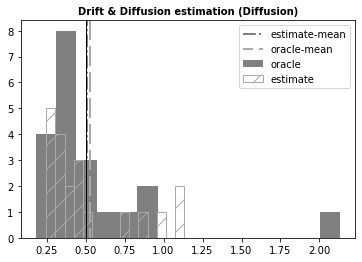

In [152]:
plt.hist(oracle_diffusion_drift[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_diffusion_drift[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_diffusion_drift[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_diffusion_drift[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('Drift & Diffusion estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-drift(diffusion).pdf")
print('empirical mean = ',np.mean(estimates_diffusion_drift[1,:]), 'empirical variance= ', np.var(estimates_diffusion_drift[1,:]))
print('oracle mean = ',np.mean(oracle_diffusion_drift[1,:]), 'oracle variance= ', np.var(oracle_diffusion_drift[1,:])) 

## VII. Minimization procedure: Estimation of the three parameters (Gradient descent)


In [16]:
trials = 100
N = 10000
n = 1000
h = 0.1
timestep = 0.1
xi = 2
sigma = 0.5
H = 0.7
p = 2

In [17]:
from numpy import linalg as LA
from scipy.optimize import fsolve
from tqdm import tqdm
from scipy.special import gamma
import scipy.integrate as integrate

In [18]:
#from scipy.stats import rv_continuous
#I = integrate.quad(lambda x: (x**2)*(1+x**2)**(-2), 0, 1000)
#I = 1/I[0]
#class gp_gen(rv_continuous):
#    "gp distribution"
#    def _pdf(self, x):
#        return I*(x**2)*(1+x**2)*(-2)
#gp = gp_gen(name='gp')


def cov_matrix(xi,sigma,H):
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 10)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 10)
    I2 = I2[0]
    non_diag_1 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi  - (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    non_diag_2 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi  - (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    diag_1 = (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    diag_2 = 2*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi  
    diag_3 = 2*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi 
    cov =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, -non_diag_2 ], [non_diag_2, -non_diag_2 ,diag_3]]
    return cov

def random_va3D(trials):
    y = np.random.uniform(0,1,trials)
    r = np.zeros(trials)
    for k in range(trials):
        #sol = fsolve(lambda x,z: (2/pi)*(np.arctan(x)-(x/(1+x**2)))-z , x0=0.5, args=y[k])
        sol = fsolve(lambda x,z: (4/pi)*(1/8)*(x*(x**2-1)/(x**2+1)**2 + np.arctan(x))-z , x0=0.5, args=y[k])
        r[k]=sol    
    phi = np.arcsin(2*np.random.uniform(0,1,trials)-1)
    theta = np.random.uniform(-pi,pi,trials)/(2*pi)
    res = np.zeros((3,trials))
    res[0,:] =r*np.cos(theta)*np.cos(phi)
    res[1,:] =r*np.sin(theta)*np.cos(phi)
    res[2,:] =r*np.sin(phi)
    return res

def oracle_loss_all(theta,x):
    eta = random_va3D(100)
    scalar_p_sample = np.zeros((n,100))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1] + eta[2,:]*x[k,2]
    cov = cov_matrix(theta[0],theta[1],theta[2])
    av_cos_euler = np.zeros(100)
    for tt in range(100):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:,tt],np.dot(cov,eta[:,tt])/2))
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample-av_cos_euler
    return np.mean(diff**2)

def loss_all(theta,x):
    z= euler_sample(N,3,timestep,theta[0],theta[1],theta[2])
    eta = random_va3D(100)
    scalar_p_sample = np.zeros((n,100))
    scalar_p_euler = np.zeros((N,100))
    for k in range(n):
        scalar_p_sample[k,:] = eta[0,:]*x[k,0]+ eta[1,:]*x[k,1] + eta[2,:]*x[k,2]
    for k in range(N):    
        scalar_p_euler[k,:] = eta[0,:]*z[k,0]+ eta[1,:]*z[k,1] + eta[2,:]*z[k,2]
    
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample-av_cos_euler
    return np.mean(diff**2)

def grad_all(theta,delta,x):
    grad1 = (loss_all(np.array([theta[0]+delta,theta[1],theta[2]]),x)-loss_all(theta,x))/delta
    grad2 = (loss_all(np.array([theta[0],theta[1]+delta,theta[2]]),x)-loss_all(theta,x))/delta
    grad3 = (loss_all(np.array([theta[0],theta[1],theta[2]+delta]),x)-loss_all(theta,x))/delta
    return np.array([grad1,grad2,grad3])

def oracle_grad_all(theta,delta,x):
    grad1 = (oracle_loss_all(np.array([theta[0]+delta,theta[1],theta[2]]),x)-oracle_loss_all(theta,x))/delta
    grad2 = (oracle_loss_all(np.array([theta[0],theta[1]+delta,theta[2]]),x)-oracle_loss_all(theta,x))/delta
    grad3 = (oracle_loss_all(np.array([theta[0],theta[1],theta[2]+delta]),x)-oracle_loss_all(theta,x))/delta
    return np.array([grad1,grad2,grad3])

def descent_all(step,delta,x):
    v0 = np.array([1.9,0.6,0.65])
    maxiter=20
    v = v0
    for i in range(maxiter):
        jac = grad_all(v,delta,x)
        timer = 0
        #print(LA.norm(jac))
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_all(v,delta,x)
            if timer == 5:
                v = v0
                jac = grad_all(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] <0 or v[0]<0 or v[2]<0 or v[2]>1:
            v = v0
        #print(jac,v)
    return v 

def oracle_descent_all(step,delta,x):
    v0 = np.array([1.9,0.65,0.6])
    maxiter=20
    v = v0
    for i in range(maxiter):
        jac = oracle_grad_all(v,delta,x)
        timer = 0
        #print(LA.norm(jac))
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_all(v,delta,x)
            if timer == 5:
                v = v0
                jac = oracle_grad_all(v,delta,x)
        if LA.norm(jac) == nan:
            v=v0
        v = v- step*jac*(i+1)**(-1)
        if v[1] <0 or v[0]<0 or v[2]<0 or v[2]>1:
            v = v0
        #print(jac,v)
    return v 

def estimator_all(trials):
    estimates = np.zeros((3,trials))
    oracle = np.zeros((3,trials))
    for trial in tqdm(range(trials)):
        x = true_sample(n,3,h,xi,sigma,H)
        res = descent_all(10,1e-1,x)
        oracle_res = oracle_descent_all(10,1e-1,x)
        print(res,oracle_res)
        estimates[:,trial] = res
        oracle[:,trial] = oracle_res
    return estimates,oracle

In [19]:
estimates,oracle = estimator_all(20)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  5%|▌         | 1/20 [00:35<11:10, 35.29s/it]

[1.8169358  0.43653368 0.70004558] [1.86798144 0.46637722 0.59584745]


  5%|▌         | 1/20 [00:38<12:20, 38.96s/it]


KeyboardInterrupt: 

empirical mean =  1.9670346324722998 empirical variance=  0.04058798310306671
oracle mean =  1.848525814940506 oracle variance=  0.043295279025550096


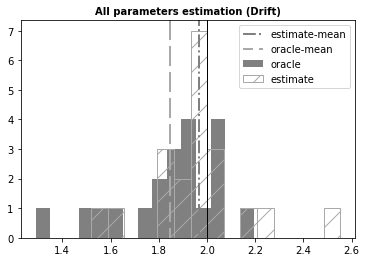

In [49]:
plt.hist(oracle[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[0,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[0,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('All parameters estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(drift).pdf")
print('empirical mean = ',np.mean(estimates[0,:]), 'empirical variance= ', np.var(estimates[0,:]))
print('oracle mean = ',np.mean(oracle[0,:]), 'oracle variance= ', np.var(oracle[0,:]))

empirical mean =  0.4082505263355749 empirical variance=  0.011388142177170622
oracle mean =  0.42343566096661933 oracle variance=  0.015004393430638465


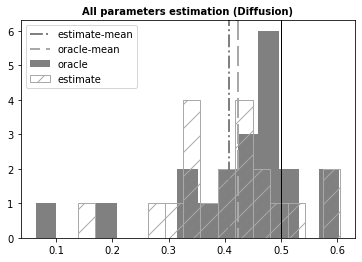

In [50]:
plt.hist(oracle[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('All parameters estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(diffusion).pdf")
print('empirical mean = ',np.mean(estimates[1,:]), 'empirical variance= ', np.var(estimates[1,:]))
print('oracle mean = ',np.mean(oracle[1,:]), 'oracle variance= ', np.var(oracle[1,:]))

empirical mean =  0.6902779954107549 empirical variance=  0.008724231534401524
oracle mean =  0.6566898759799599 oracle variance=  0.02784117320965789


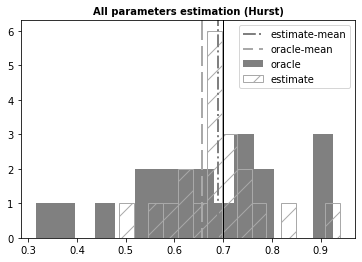

In [51]:
plt.hist(oracle[2,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[2,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[2,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[2,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('All parameters estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(hurst).pdf")
print('empirical mean = ',np.mean(estimates[2,:]), 'empirical variance= ', np.var(estimates[2,:]))
print('oracle mean = ',np.mean(oracle[2,:]), 'oracle variance= ', np.var(oracle[2,:]))

In [86]:
# pb=1 -> xi and H, pb=2 -> xi and sigma, pb=3 -> H and sigma
from scipy.special import psi
from tqdm import tqdm
from scipy.special import gamma
import scipy.integrate as integrate


from scipy.stats import rv_continuous
I = integrate.quad(lambda x: (x**2)*(1+x**2)**(-2), 0, 1000)
I = 1/I[0]
class gp_gen(rv_continuous):
    "gp distribution"
    def _pdf(self, x):
        return I*(x**2)*(1+x**2)*(-2)
gp = gp_gen(name='gp')

def random_va(trials):
    r = gp.rvs(size=trials)
    v = np.arccos(1-2*np.random.uniform(0,1,trials))
    u = np.random.uniform(0,2*pi,trials)
    return [r*np.cos(u)*np.sin(v), r*np.sin(u)*np.sin(v), r*np.cos(v)]

In [87]:
def cov_matrix(xi,H,sigma):
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    non_diag_1 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi  - (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    non_diag_2 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi  - (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    diag_1 = (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)
    diag_2 = 2*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi  
    diag_3 = 2*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi 
    cov =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, -non_diag_2 ], [non_diag_2, -non_diag_2 ,diag_3]]
    return cov


def partial_cov(xi,H,sigma):
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    non_diag_1 = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I1/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    non_diag_2 = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I2/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_1 = (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_2 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I1/pi  
    diag_3 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I2/pi  
    cov_sigma =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, -non_diag_2 ], [non_diag_2, -non_diag_2 ,diag_3]]
    

    I1 = integrate.quad(lambda x: -cos(h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: -cos(2*h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I2 = I2[0]
    non_diag_1 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi  - (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    non_diag_2 = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi  - (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_1 = (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_2 = 2*(-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi 
    diag_3 = 2*(-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi 
    cov_xi = [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, -non_diag_2 ], [non_diag_2, -non_diag_2 ,diag_3]]
    
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    II1 = integrate.quad(lambda x: (-2*log(x))*cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II1 = II1[0]
    II2 = integrate.quad(lambda x: (-2*log(x))*cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II2 = II2[0]
    non_diag_1 = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I1 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I1/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II1/pi  - (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) - (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    non_diag_2 = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I2 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I2/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II2/pi  - (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) - (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_1 = (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) + (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_2 = 2*diag_1 -2*( (sigma**2)*gamma(2*H+1)*cos(pi*H)*I1 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I1/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II1/pi  )
    diag_3 = 2*diag_1 -2*( (sigma**2)*gamma(2*H+1)*cos(pi*H)*I2 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I2/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II2/pi  )
    cov_H =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, -non_diag_2 ], [non_diag_2, -non_diag_2 ,diag_3]]
    
    return [cov_xi, cov_H, cov_sigma]

In [88]:
def cov_matrixv2(xi,H,sigma):
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    txt =  (sigma**2)*(H*gamma(2*H) )*xi**(-2*H)  
    hxt = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi 
    h2xt = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi
    
    non_diag_1 = hxt  - txt
    non_diag_2 = 2*hxt - 2*txt
    non_diag_3 = 3*txt + h2xt - 4*hxt
    diag_1 = txt
    diag_2 = 2*txt -2*hxt
    diag_3 = 6*txt + 2*h2xt - 8*h2xt
    cov =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, non_diag_3 ], [non_diag_2, non_diag_3 ,diag_3]]
    return cov


def partial_covv2(xi,H,sigma):
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    
    txt =  (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)  
    hxt = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I1/pi
    h2xt = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I2/pi
    
    non_diag_1 = hxt  - txt
    non_diag_2 = 2*hxt - 2*txt
    non_diag_3 = 3*txt + h2xt - 4*hxt
    diag_1 = txt
    diag_2 = 2*txt -2*hxt
    diag_3 = 6*txt + 2*h2xt - 8*h2xt
    cov_sigma =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, non_diag_3 ], [non_diag_2, non_diag_3 ,diag_3]]
    

    I1 = integrate.quad(lambda x: -cos(h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: -cos(2*h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I2 = I2[0]
    txt =  (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    hxt = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I1/pi
    h2xt = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I2/pi
    
    non_diag_1 = hxt  - txt
    non_diag_2 = 2*hxt - 2*txt
    non_diag_3 = 3*txt + h2xt - 4*hxt
    diag_1 = txt
    diag_2 = 2*txt -2*hxt
    diag_3 = 6*txt + 2*h2xt - 8*h2xt
    cov_xi = [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, non_diag_3 ], [non_diag_2, non_diag_3 ,diag_3]]
    
    I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I1 = I1[0]
    I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I2 = I2[0]
    II1 = integrate.quad(lambda x: (-2*log(x))*cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II1 = II1[0]
    II2 = integrate.quad(lambda x: (-2*log(x))*cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II2 = II2[0]
    txt =  (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) + (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    hxt = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I1 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I1/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II1/pi 
    h2xt = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I2 + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I2/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II2/pi 
    
    non_diag_1 = hxt  - txt
    non_diag_2 = 2*hxt - 2*txt
    non_diag_3 = 3*txt + h2xt - 4*hxt
    diag_1 = txt
    diag_2 = 2*txt -2*hxt
    diag_3 = 6*txt + 2*h2xt - 8*h2xt
    cov_H =  [[diag_1, non_diag_1, non_diag_2 ],[non_diag_1,diag_2, non_diag_3 ], [non_diag_2, non_diag_3 ,diag_3]]
    
    return [cov_xi, cov_H, cov_sigma]

In [89]:
def gradient(x,theta):
    Eta = random_va(100)
    g = []
    cov_partial = partial_cov(theta[0],theta[1],theta[2])
    cov_partial = np.array(cov_partial)    
    matrix_cov = np.array(cov_matrix(theta[0],theta[1],theta[2]))
    
    for i in range(100):
        eta = [Eta[0][i],Eta[1][i],Eta[2][i]]
        av = np.mean(np.cos(np.inner(eta,x)))
        r = -0.5*np.inner(eta,matrix_cov.dot(eta))
        r0 = -0.5*np.inner(eta,cov_partial[0].dot(eta))
        r1 = -0.5*np.inner(eta,cov_partial[1].dot(eta))
        r2 = -0.5*np.inner(eta,cov_partial[2].dot(eta))
        g += [ [-2*(av - np.exp(r))*r0 , -2*(av - np.exp(r))*r1 , -2*(av - np.exp(r))*r2]  ]
    g = np.array(g)    
    return np.array([np.mean(g[:,0]),np.mean(g[:,1]), np.mean(g[:,2])])  

def gradientv2(x,theta):
    Eta = random_va(100)
    g = []
    cov_partial = partial_covv2(theta[0],theta[1],theta[2])
    cov_partial = np.array(cov_partial)    
    matrix_cov = np.array(cov_matrixv2(theta[0],theta[1],theta[2]))
    
    for i in range(100):
        eta = [Eta[0][i],Eta[1][i],Eta[2][i]]
        av = np.mean(np.cos(np.inner(eta,x)))
        r = -0.5*np.inner(eta,matrix_cov.dot(eta))
        r0 = -0.5*np.inner(eta,cov_partial[0].dot(eta))
        r1 = -0.5*np.inner(eta,cov_partial[1].dot(eta))
        r2 = -0.5*np.inner(eta,cov_partial[2].dot(eta))
        g += [ [-2*(av - np.exp(r))*r0 , -2*(av - np.exp(r))*r1 , -2*(av - np.exp(r))*r2]  ]
    g = np.array(g)    
    return np.array([np.mean(g[:,0]),np.mean(g[:,1]), np.mean(g[:,2])])  

In [90]:
xi = 2
sigma = 0.5
H = 0.7

nb = 10
h = 0.1
n = 10000
x = true_sample(n,3,h,xi,sigma,H)

100%|██████████| 1000300/1000300 [00:05<00:00, 190925.84it/s]


In [91]:
def incrementsv2(x,q):
    n = len(x)-2*q
    X = np.zeros((n,q))
    for i in range(2,q):
        X[:,i] = x[q+i:q+i+n] - 2*x[q:q+n] + x[q-i:q+n-i]
    X[:,1] = x[q+i:q+i+n] - x[q:q+n]   
    X[:,0] = x[q:q+n]    
    return X    


def true_samplev2(n,q,h,xi,sigma,H):
    dt = 0.001
    x = ornstein_uhlenbeck(dt,int((n+2*q)*(h/dt)), xi, sigma, H)
    good_indices = [i for i in range(int((n+2*q)*(h/dt))) if i % int(1/h) == 0]
    x = np.array([x[i] for i in good_indices])
    X = incrementsv2(x,q)
    return X

In [92]:
x2 = true_samplev2(n,3,h,xi,H,sigma)

100%|██████████| 1000600/1000600 [00:05<00:00, 195010.87it/s]


In [93]:
from numpy import linalg as LA

def comparison(x,y):
    l = 0
    n = len(x)
    for i in range(n):
        l += abs(x[i])/abs(y[i])
    return l/n    
        

theta0 = np.array([2.5,0.5,0.7])
theta0_2 = np.array([1,0.8,0.6])

it = 200
lossv1 = np.zeros(it)
lossv2 = np.zeros(it)
lossv1_2 = np.zeros(it)
lossv2_2 = np.zeros(it)

thetav1 = np.array(theta0)
thetav1_2 = np.array(theta0_2)
thetav2 = np.array(theta0)
thetav2_2 = np.array(theta0_2)

stepsize1 = np.array([0.15,0.03,0.03])
stepsize1_2 = np.array([0.05,0.01,0.01])
stepsize2 = np.array([0.05,0.01,0.001])
stepsize2_2 = np.array([0.005,0.01,0.001])

true_theta = [xi,H, sigma]

for i in tqdm(range(it)):
    gradv1 = gradient(x,[thetav1[0],thetav1[1], thetav1[2]])
    while LA.norm(gradv1) > 100:
        gradv1 = gradient(x,[thetav1[0],thetav1[1], thetav1[2]])
    print(gradv1*stepsize1)
    
    gradv1_2 = gradient(x,[thetav1_2[0],thetav1_2[1], thetav1_2[2]])
    while LA.norm(gradv1) > 100:
        gradv1_2 = gradient(x,[thetav1_2[0],thetav1_2[1], thetav1_2[2]])
    print(gradv1_2*stepsize1_2)
    
    #gradv2 = gradientv2(x2,[thetav2[0],thetav2[1], thetav2[2]])
    #while LA.norm(gradv2) > 100:
    #    gradv2 = gradientv2(x2,[thetav2[0],thetav2[1], thetav2[2]])
    #print(gradv2)
    
    #gradv2_2 = gradientv2(x2,[thetav2_2[0],thetav2_2[1], thetav2_2[2]])
    #while LA.norm(gradv2_2) > 100:
    #    gradv2_2 = gradientv2(x2,[thetav2_2[0],thetav2_2[1], thetav2_2[2]])
    #print(gradv2_2)
        
    thetav1 = thetav1 - gradv1*stepsize1
    #thetav2 = thetav2 - gradv2*stepsize2*((1+i)**(-1/2))
    #thetav1_2 = thetav1_2 - gradv1_2*stepsize1_2
    #thetav2_2 = thetav2_2 - gradv2_2*stepsize2_2*((1+i)**(-1/2))

    lossv1[i] = comparison(thetav1-true_theta,theta0-true_theta )
    #lossv2[i] = comparison(thetav2-true_theta,theta0-true_theta )
    #lossv1_2[i] = comparison(thetav1_2-true_theta,theta0_2-true_theta )
    #lossv2_2[i] = comparison(thetav2_2-true_theta,theta0_2-true_theta )

  0%|          | 0/200 [00:00<?, ?it/s]/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficultie

[-0.04371751 -0.76310574  0.4484616 ]


  0%|          | 1/200 [00:05<18:19,  5.52s/it]

[ 0.02716653 -0.07916298  0.02137996]


<ipython-input-87-1e262e4ec039>:16: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
<ipython-input-87-1e262e4ec039>:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I2 = integrate.quad(lambda x: cos(2*h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
<ipython-input-87-1e262e4ec039>:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I1 = integrate.quad(lambda x: -cos(h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
<ipython-input-87-1e262e4ec039>:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I2 = integrate.quad(lambda x: -cos(2*h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
<ipython-input-87-1e262e4ec039>:39: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I1 = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
<ipython-

[0.03595319 0.10662837 0.16328711]


  1%|          | 2/200 [00:11<18:26,  5.59s/it]

[ 0.01293168 -0.06364599  0.02115312]
[ 0.04550916  0.01015696 -0.18440479]


  2%|▏         | 3/200 [00:16<18:26,  5.62s/it]

[-0.00455368 -0.10829532  0.0499111 ]
[0.0584019  0.13565562 0.03802826]


  2%|▏         | 4/200 [00:22<18:20,  5.61s/it]

[ 0.00085103 -0.06438607  0.02776981]
[ 0.05170739  0.06152532 -0.10055279]


  2%|▎         | 5/200 [00:28<18:10,  5.59s/it]

[ 0.01538051 -0.08521603  0.0298467 ]
[ 0.02278762  0.02614362 -0.03934207]


  3%|▎         | 6/200 [00:33<18:07,  5.60s/it]

[ 0.01088514 -0.05365234  0.01832148]
[ 0.01871213  0.00811969 -0.02755687]


  4%|▎         | 7/200 [00:39<18:18,  5.69s/it]

[-0.00231579 -0.09114611  0.04153418]
[ 0.00917591 -0.01883935 -0.00625842]


  4%|▍         | 8/200 [00:45<18:06,  5.66s/it]

[ 0.02373311 -0.04814402  0.00911852]
[ 0.01410543 -0.0058461  -0.01582202]


  4%|▍         | 9/200 [00:50<17:55,  5.63s/it]

[-0.01521124 -0.09964079  0.05126832]
[ 0.01112668 -0.01859459 -0.00917209]


  5%|▌         | 10/200 [00:56<17:47,  5.62s/it]

[ 0.02089454 -0.09182986  0.0301021 ]
[ 0.01921142  0.01183353 -0.02281849]


  6%|▌         | 11/200 [01:01<17:41,  5.61s/it]

[-0.00014065 -0.08786767  0.03862846]
[ 0.01640337 -0.00809947 -0.0159186 ]


  6%|▌         | 12/200 [01:07<17:29,  5.58s/it]

[ 0.01948211 -0.07088357  0.02069586]
[ 0.01393447 -0.01367794 -0.01209782]


  6%|▋         | 13/200 [01:13<17:26,  5.60s/it]

[ 0.01887667 -0.05977835  0.01716296]
[ 0.01905635  0.00285874 -0.01847136]


  7%|▋         | 14/200 [01:18<17:23,  5.61s/it]

[ 0.01535152 -0.07603261  0.02563219]
[ 0.01549807 -0.01707438 -0.01250726]


  8%|▊         | 15/200 [01:24<17:27,  5.66s/it]

[ 0.02102292 -0.10882272  0.03803318]
[ 0.02399729  0.02861871 -0.02229858]


  8%|▊         | 16/200 [01:30<17:23,  5.67s/it]

[ 0.02951331 -0.05165952  0.00769326]
[ 0.01617061 -0.04426686 -0.00838759]


  8%|▊         | 17/200 [01:35<17:20,  5.68s/it]

[ 0.00833949 -0.07777887  0.02996784]
[ 0.03467073  0.07209263 -0.02780839]


  9%|▉         | 18/200 [01:41<17:19,  5.71s/it]

[-0.01179678 -0.09671812  0.0485473 ]
[ 0.00386454 -0.09784194  0.01435145]


 10%|▉         | 19/200 [01:47<17:04,  5.66s/it]

[ 0.00529942 -0.07786662  0.03198423]
[0.02609005 0.39772834 0.00688342]


 10%|█         | 20/200 [01:52<17:02,  5.68s/it]

[ 0.02074506 -0.06022789  0.01610706]
[-0.02055816 -0.22872419  0.16517799]


 10%|█         | 21/200 [01:58<16:54,  5.67s/it]

[-0.0030094  -0.08854596  0.04007624]
[ 0.00755831 -0.03124692  0.00502317]


 11%|█         | 22/200 [02:04<17:02,  5.75s/it]

[ 0.01303873 -0.07607377  0.0273741 ]
[ 0.00908282 -0.03643807  0.00283106]


 12%|█▏        | 23/200 [02:10<17:05,  5.79s/it]

[ 0.01482606 -0.0634739   0.02034247]
[ 0.01617266 -0.00146588 -0.01922133]


 12%|█▏        | 24/200 [02:16<17:04,  5.82s/it]

[ 0.00570298 -0.06887397  0.02740088]
[ 0.01541383 -0.01971225 -0.01244356]


 12%|█▎        | 25/200 [02:22<16:56,  5.81s/it]

[ 0.01633314 -0.07181185  0.02313646]
[ 0.01863239 -0.00252836 -0.0195616 ]


 13%|█▎        | 26/200 [02:27<16:48,  5.79s/it]

[-0.0025378  -0.08528976  0.03812169]
[ 0.01594119 -0.01470592 -0.01358525]


 14%|█▎        | 27/200 [02:33<16:47,  5.82s/it]

[ 0.00872124 -0.10236735  0.04044375]
[ 0.02034186 -0.00378932 -0.01904546]


 14%|█▍        | 28/200 [02:39<16:38,  5.80s/it]

[ 0.01498391 -0.05776519  0.01773879]
[ 0.02046398 -0.00250123 -0.01828024]


 14%|█▍        | 29/200 [02:45<16:28,  5.78s/it]

[-4.94806897e-05 -7.08786092e-02  3.13419242e-02]
[ 0.01839108 -0.01029332 -0.01480922]


 15%|█▌        | 30/200 [02:50<16:12,  5.72s/it]

[ 0.01680844 -0.06595933  0.02020353]
[ 0.02179523  0.00508113 -0.01814846]


 16%|█▌        | 31/200 [02:56<16:14,  5.77s/it]

[ 0.01447028 -0.09759928  0.03586238]
[ 0.0231487  -0.01148977 -0.01725091]


 16%|█▌        | 32/200 [03:02<16:04,  5.74s/it]

[ 0.0047579  -0.06667111  0.02713942]
[ 0.02416962  0.00552219 -0.01810806]


 16%|█▋        | 33/200 [03:08<15:58,  5.74s/it]

[-0.00644607 -0.09220628  0.04402596]
[ 0.0271468  -0.01720794 -0.01829016]


 17%|█▋        | 34/200 [03:13<15:49,  5.72s/it]

[ 0.00972401 -0.08431771  0.03192279]
[ 0.03765925  0.02939885 -0.02530061]


 18%|█▊        | 35/200 [03:19<15:38,  5.69s/it]

[ 0.0172927  -0.04679012  0.0119162 ]
[ 0.02227855 -0.03799621 -0.01118434]


 18%|█▊        | 36/200 [03:25<15:33,  5.69s/it]

[ 0.02616226 -0.05615054  0.01126517]


<ipython-input-87-1e262e4ec039>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I2 = integrate.quad(lambda x: -cos(2*h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)


[ 4.67984803  0.18487152 -0.01708925]


 18%|█▊        | 37/200 [03:30<15:28,  5.70s/it]

[ 0.00793774 -0.06481037  0.02471118]


<ipython-input-87-1e262e4ec039>:20: RuntimeWarning: invalid value encountered in double_scalars
  non_diag_1 = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I1/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
<ipython-input-87-1e262e4ec039>:21: RuntimeWarning: invalid value encountered in double_scalars
  non_diag_2 = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I2/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
<ipython-input-87-1e262e4ec039>:22: RuntimeWarning: invalid value encountered in double_scalars
  diag_1 = (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
<ipython-input-87-1e262e4ec039>:23: RuntimeWarning: invalid value encountered in double_scalars
  diag_2 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I1/pi
<ipython-input-87-1e262e4ec039>:24: RuntimeWarning: invalid value encountered in double_scalars
  diag_3 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I2/pi
<ipython-input-87-1e262e4ec039>:32: RuntimeWarning: invalid value encountered in double_scalars
  non_

ValueError: math domain error

In [ ]:
plt.plot(np.linspace(1,it,it)[:100],lossv1[:100], label='Estimation of all parameters')  
#plt.plot(np.linspace(1,it,it),lossv2, label= '2nd order increments')  
#plt.plot(np.linspace(1,it,it),lossv1_2, label= 'initial point = [1,0.8,0.6]')  
#plt.plot(np.linspace(1,it,it),lossv2_2, label= '2nd order increments') 

plt.title('')
plt.legend()
plt.savefig('xiHandsigma.pdf')
print(thetav1, theta0,true_theta)

In [41]:
[1e-6*5000*i for i in range(1,10)]

[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]

In [28]:
def loss(theta,theta0):
    Eta = random_va(100)
    g = []  
    matrix_cov = np.array(cov_matrix(theta[0],theta[1],theta[2]))
    matrix_cov0 = np.array(cov_matrix(theta0[0],theta0[1],theta0[2]))
    
    for i in range(100):
        eta = [Eta[0][i],Eta[1][i],Eta[2][i]]
        av = np.mean(np.cos(np.inner(eta,x)))
        r = -0.5*np.inner(eta,matrix_cov.dot(eta))
        r0 = -0.5*np.inner(eta,matrix_cov0.dot(eta))
        g += [(np.exp(r0) - np.exp(r))**2] 
    g = np.array(g)    
    return np.mean(g)


    

In [29]:
print(loss(thetav1,[2,0.7,0.5]),loss(thetav2_2,[2,0.7,0.5]))

/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diffi

0.05185440474668249 0.0002740839444147585


In [44]:
print(thetav2_2)

[1.  0.8 0.6]


In [45]:
print(thetav1)

[1.29266398 0.98680199 0.42211413]


In [53]:
print(LA.norm(thetav1-np.array([2,0.7,0.5])),LA.norm(thetav2_2-np.array([2,0.7,0.5])))

0.7672325845333978 1.0099504938362078


# VIII. Beyond the fractional Ornstein-Uhlenbeck

In [ ]:
from numpy import linalg as LA
import numpy as np
from math import *
import matplotlib.pyplot as plt

def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))
def deriv_sigmoid(x):
    
def ortog(x):
    return np.array([-x[1],x[0]])

eps = 0.1    

def processandpartial(dt,n,drift,sigma,H):
    T = dt*n
    trials=1
    B = fBm(T,n,H,trials)
    B = B[:,0]
    x = np.zeros((n+1,2))
    x_xi = np.zeros((n+1,2))
    for i in range(n):
        S =  sigmoid(1+LA.norm(x[i,:])**2)
        SS = 
        x[i+1,:] = x[i,:] - dt * x[i,:] * S * drift + dt * eps*ortog(x[i,:])  + sigma*(B[i+1]-B[i])
        x_xi[i+1,:] = x_xi[i,:] + dt * (- x[i,:]*S) + np.array(([[- drift *S - drift*x[i,0]*],[]]).dot(x_xi[i,:]) )
    return x  

def increments(x,q):
    n = len(x)-q
    X = np.zeros((n,q))
    for i in range(1,q):
        X[:,i] = x[i:i+n] - x[0:n]
    X[:,0] = x[0:n]    
    return X    


def true_sample(n,q,h,xi,sigma,H):
    dt = 0.001
    x = ornstein_uhlenbeck(dt,int((n+q)*(h/dt)), xi, sigma, H)
    good_indices = [i for i in range(int((n+q)*(h/dt))) if i % int(1/h) == 0]
    x = np.array([x[i] for i in good_indices])
    X = increments(x,q)
    return X

def euler_sample(n,q,gamma,xi,sigma,H):
    x = ornstein_uhlenbeck(gamma,n+q, xi, sigma, H)
    X = increments(x,q)
    return X
    
    
    
from scipy.special import psi
from tqdm import tqdm
from scipy.special import gamma
import scipy.integrate as integrate


from scipy.stats import rv_continuous
I = integrate.quad(lambda x: (x**2)*(1+x**2)**(-2), 0, np.inf)
I = 1/I[0]
class gp_gen(rv_continuous):
    "gp distribution"
    def _pdf(self, x):
        return I*(x**2)*(1+x**2)*(-2)
gp = gp_gen(name='gp')

def random_va(trials):
    r = gp.rvs(size=trials)
    v = np.arccos(1-2*np.random.uniform(0,1,trials))
    u = np.random.uniform(0,2*pi,trials)
    return [r*np.cos(u)*np.sin(v), r*np.sin(u)*np.sin(v), r*np.cos(v)]


def gradientv(x,theta):
    Eta = random_va(100)
    g = []
    cov_partial = partial_covv2(theta[0],theta[1],theta[2])
    cov_partial = np.array(cov_partial)    
    matrix_cov = np.array(cov_matrixv2(theta[0],theta[1],theta[2]))
    
    for i in range(100):
        eta = [Eta[0][i],Eta[1][i],Eta[2][i]]
        av = np.mean(np.cos(np.inner(eta,x)))
        r = -0.5*np.inner(eta,matrix_cov.dot(eta))
        r0 = -0.5*np.inner(eta,cov_partial[0].dot(eta))
        r1 = -0.5*np.inner(eta,cov_partial[1].dot(eta))
        r2 = -0.5*np.inner(eta,cov_partial[2].dot(eta))
        g += [ [-2*(av - np.exp(r))*r0 , -2*(av - np.exp(r))*r1 , -2*(av - np.exp(r))*r2]  ]
    g = np.array(g)    
    return np.array([np.mean(g[:,0]),np.mean(g[:,1]), np.mean(g[:,2])])      

In [ ]:
sqrt(4)